In [35]:
import pandas as pd
import numpy as np
df1 = pd.read_csv("/kaggle/input/tmdb-movie-metadata/tmdb_5000_credits.csv")
df2 = pd.read_csv("/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv")

df1.columns = ["id" , "tittle" , "cast" , "crew"]
df2 = df2.merge(df1 , on = 'id')


In [36]:
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

For any of you who has done even a bit of text processing before knows we need to convert the word vector of each overview. Now we'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

Now if you are wondering what is term frequency , it is the relative frequency of a word in a document and is given as (term instances/total instances). Inverse Document Frequency is the relative count of documents containing the term is given as log(number of documents/documents with term) The overall importance of each word to the documents in which they appear is equal to TF * IDF

This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each row represents a movie, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

Fortunately, scikit-learn gives you a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines. 

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words = "english")

# Replace NaN with empty string
df2['overview'] = df2['overview'].fillna('')

# Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])

# Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

We see that over 20,000 different words were used to describe the 4800 movies in our dataset.

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the cosine similarity scores. There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:
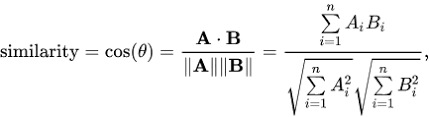

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster.

In [38]:
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix , tfidf_matrix)

We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [39]:
# Construct a reverse map of indices and movie titles
indices = pd.Series(df2.index , index = df2['title']).drop_duplicates()

We are now in a good position to define our recommendation function. These are the following steps we'll follow :-

*  Get the index of the movie given its title.
*  Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
*  Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
*  Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
*  Return the titles corresponding to the indices of the top elements.

In [40]:
def get_recommendations(title , cosine_sim = cosine_sim):
    # Get index of the movies that matches the input
    idx = indices[title]
    
    # Get the pairwise similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on similarity scores
    sim_scores = sorted(sim_scores , key=lambda x:x[1] , reverse = True)
    
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]

In [41]:
get_recommendations('The Avengers')

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: title, dtype: object

### Credits, Genres and Keywords Based Recommender¶
It goes without saying that the quality of our recommender would be increased with the usage of better metadata. That is exactly what we are going to do in this section. We are going to build a recommender based on the following metadata: the 3 top actors, the director, related genres and the movie plot keywords.

From the cast, crew and keywords features, we need to extract the three most important actors, the director and the keywords associated with that movie. Right now, our data is present in the form of "stringified" lists , we need to convert it into a safe and usable structure

In [42]:
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)
    
# Get the director's name from the crew feature . If director is not listed , return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [43]:
# Return the list top 3 elements or entire list
def get_list(x):
    if isinstance(x,list):
        names = [i['name'] for i in x]
        # Check if more than 3 elements exist . If yes , return first three
        # Else return entire list
        if len(names)>3:
            names = names[:3]
        return names
    # Return empty list in case of missing/malformed data
    return []

In [44]:
# Define new director , cast , genres and keywords features
# that are in a suitable form
df2['director'] = df2['crew'].apply(get_director)
features = ['cast','keywords','genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)
    
df2[['title','cast','director','keywords','genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.

In [45]:
def clean_data(x):
    if isinstance(x,list):
        return [str.lower(i.replace(" ","")) for i in x]
    else:
        # Check if director exist , if not return empty
        if isinstance(x,str):
            return str.lower(x.replace(" ",""))
        else:
            return ""

In [46]:
features = ['cast','keywords','director','genres']
for i in features:
    df2[i] = df2[i].apply(clean_data)

"metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer (namely actors, director and keywords).

In [47]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' +x['director']+' '+' '.join(x['genres']) 
df2['soup'] = df2.apply(create_soup , axis = 1)

The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the CountVectorizer() instead of TF-IDF. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words = 'english')
count_matrix = count.fit_transform(df2['soup'])

# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix , count_matrix)

# Reset index of main DataFrame and construct reverse mapping as before
df2 = df2.reset_index()
indices = pd.Series(df2.index, index = df2['title'])

In [50]:
get_recommendations("The Dark Knight",cosine_sim2)

3          The Dark Knight Rises
119                Batman Begins
4638    Amidst the Devil's Wings
2398                      Hitman
1720                    Kick-Ass
1740                  Kick-Ass 2
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
Name: title, dtype: object